plan here is to create a timeseries plot of returns to understand the behaviour (in pnl form) of the strategy

In [1]:
# importing packages and data

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

df = pd.read_csv("extended_data.csv", 
dtype={0: float, 1: str, 2: float,  3: float,  4: float,  5: float,  6: float,  7: float,  8: int}
)

# fill missed funding periods with 0
df["funding"] = df["funding"].fillna(0)

# check number of assets
print(len(df["asset"].unique()))

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

57
Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate]
Index: []


alter ANNUAL_VOLATILITY here to understand how it plays out in timeseries plot at the end of the notebook

In [2]:
# define constants
RETURNS_LOOKBACK = 30
ANNUAL_VOLATILITY = 2
TARGET_VOLATILITY = ANNUAL_VOLATILITY/math.sqrt(365)
print(TARGET_VOLATILITY)

0.10468478451804275


In [3]:
# making time readable
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# getting returns and return and funding volatility

# asset retuns
df["returns"] = (
    df.groupby("asset")["close"]
      .transform(lambda x: x.pct_change())
)

# asset returns inclusive of funding
df["returns_funding"] = df["returns"] - df["funding"]

# next day asset returns inclusive of funding
df["next_returns_funding"] = (
    df.groupby("asset")["returns_funding"]
      .shift(-1)
)

# asset returns and funding volatility
df["rolling_returns_funding_vol"] = (
    df.groupby("asset")["returns_funding"]
      .rolling(window=RETURNS_LOOKBACK)
      .std()
      .reset_index(level=0, drop=True)
)

# creating dollar volume
df["dollar_volume"] = df["volume"] * df["close"]

# rolling median volume
df["rolling_volume"] = (
    df.groupby("asset")["dollar_volume"]
      .rolling(window=RETURNS_LOOKBACK)
      .median()
      .reset_index(level=0, drop=True)
)

# check work
df.iloc[50:56].head()

,timestamp,asset,open,high,low,close,volume,funding,funding inaccurate,returns,returns_funding,next_returns_funding,rolling_returns_funding_vol,dollar_volume,rolling_volume
50,2025-01-25 20:00:00,1000BONK-USD,0.029637,0.029813,0.028716,0.029260,574900.0,-0.000037,24,-0.012721,-0.012684,-0.154063,0.075372,16821.5740,22175.4006
51,2025-01-26 20:00:00,1000BONK-USD,0.029260,0.029260,0.024299,0.024748,1239300.0,-0.000141,24,-0.154204,-0.154063,0.008947,0.080323,30670.1964,22175.4006
52,2025-01-27 20:00:00,1000BONK-USD,0.024748,0.026785,0.024748,0.024954,982400.0,-0.000623,24,0.008324,0.008947,-0.001621,0.079880,24514.8096,22511.5796
53,2025-01-28 20:00:00,1000BONK-USD,0.024954,0.025741,0.022771,0.024913,1317900.0,-0.000022,24,-0.001643,-0.001621,0.014194,0.079750,32832.8427,22856.8046
54,2025-01-29 20:00:00,1000BONK-USD,0.024913,0.026438,0.023934,0.025254,1091300.0,-0.000506,24,0.013688,0.014194,-0.012058,0.079690,27559.6902,22856.8046


In [4]:
# creating funding signals

for i in [3, 5, 10, 15, 25, 40, 55]:
    
    df[f"funding_sig_1v{i}"] = (
    df.groupby("asset")["funding"]
      .rolling(window=i)
      .mean()
      .reset_index(level=0, drop=True)
    )

    df[f"funding_sig_2v{i}"] = df["funding"] - df[f"funding_sig_1v{i}"]

df = df.drop(columns = ["funding_sig_1v40", "funding_sig_1v55"])

In [5]:
# scaling returns and funding by volatility
df["returns_funding_volscaled"] = df["returns_funding"]*(TARGET_VOLATILITY/df["rolling_returns_funding_vol"])

# next day asset returns and funding scaled by volatility
df["next_returns_funding_volscaled"] = (
    df.groupby("asset")["returns_funding_volscaled"]
      .shift(-1)
)

# editing to remove what wont yet include a volatility scale and final day
df = df[df.groupby('asset').cumcount() > 55].copy()
df = df.groupby('asset').head(-1).copy()

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate, returns, returns_funding, next_returns_funding, rolling_returns_funding_vol, dollar_volume, rolling_volume, funding_sig_1v3, funding_sig_2v3, funding_sig_1v5, funding_sig_2v5, funding_sig_1v10, funding_sig_2v10, funding_sig_1v15, funding_sig_2v15, funding_sig_1v25, funding_sig_2v25, funding_sig_2v40, funding_sig_2v55, returns_funding_volscaled, next_returns_funding_volscaled]
Index: []

[0 rows x 29 columns]


In [6]:
idx_max = df["next_returns_funding_volscaled"].idxmax()
print(df.loc[idx_max])
idx_min = df["next_returns_funding_volscaled"].idxmin()
print(df.loc[idx_min])

timestamp                         2025-02-28 20:00:00
asset                                         ADA-USD
open                                            0.636
high                                           0.6517
low                                            0.6282
close                                          0.6424
volume                                         1560.0
funding                                     -0.000301
funding inaccurate                                 24
returns                                      0.010063
returns_funding                              0.010364
next_returns_funding                         0.620888
rolling_returns_funding_vol                  0.042673
dollar_volume                                1002.144
rolling_volume                              1724.8026
funding_sig_1v3                              0.000526
funding_sig_2v3                             -0.000827
funding_sig_1v5                              0.000498
funding_sig_2v5             

In [7]:
corr_signals = ['funding_sig_1v15', 'funding_sig_1v10', 'funding_sig_2v40', 
                'funding_sig_2v25', 'funding_sig_2v55']


df["avg_signal"] = 0

df["avg_signal"] = df[corr_signals].mean(axis=1)

In [8]:
# create deciles
df["avgsignal_decile"] = 0

# per day deciles across all assets
df['avgsignal_decile'] = df.groupby('timestamp')['avg_signal'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

df["volume_decile"] = 0

# per day deciles across all assets
df['volume_decile'] = df.groupby('timestamp')['rolling_volume'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 3, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
56    2025-01-31 20:00:00  1000BONK-USD       0.024936       0.025613   
472   2025-01-31 20:00:00  1000PEPE-USD       0.014007       0.014258   
762   2025-01-31 20:00:00  1000SHIB-USD       0.018872       0.019227   
1411  2025-01-31 20:00:00       ADA-USD       0.945700       0.954300   
1852  2025-01-31 20:00:00       ARB-USD       0.649000       0.651800   
2271  2025-01-31 20:00:00      AVAX-USD      34.720000      35.070000   
2909  2025-01-31 20:00:00       BNB-USD     679.200000     681.400000   
3332  2025-01-31 20:00:00       BTC-USD  102375.600000  102753.100000   
3780  2025-01-31 20:00:00      DOGE-USD       0.327960       0.330150   
4475  2025-01-31 20:00:00       ETH-USD    3339.420000    3341.010000   
5021  2025-01-31 20:00:00      GOAT-USD       0.203700       0.207700   
6751  2025-01-31 20:00:00      LINK-USD      24.897000      25.905000   
7157  2025-01-31 20:00:00       LTC-USD     126.150

In [9]:
# timeseries plot of returns
long_basket = df[((df["avgsignal_decile"] <= 3) & (df["volume_decile"] >= 1))].copy()

short_basket = df[(df["avgsignal_decile"].between(5, 8)) & (df["volume_decile"] <= 1)].copy()
short_basket["next_returns_funding_volscaled"] = short_basket["next_returns_funding_volscaled"] * -1

long_short_basket = df[((df["avgsignal_decile"] <= 3) & (df["volume_decile"] >= 1)) | ((df["avgsignal_decile"].between(5, 8)) & (df["volume_decile"] <= 1))].copy()
long_short_basket.loc[(df["avgsignal_decile"].between(5, 8)),"next_returns_funding_volscaled"] *= -1

print(len(long_basket))
print(len(short_basket))
print(len(long_short_basket))

3110
3034
6144


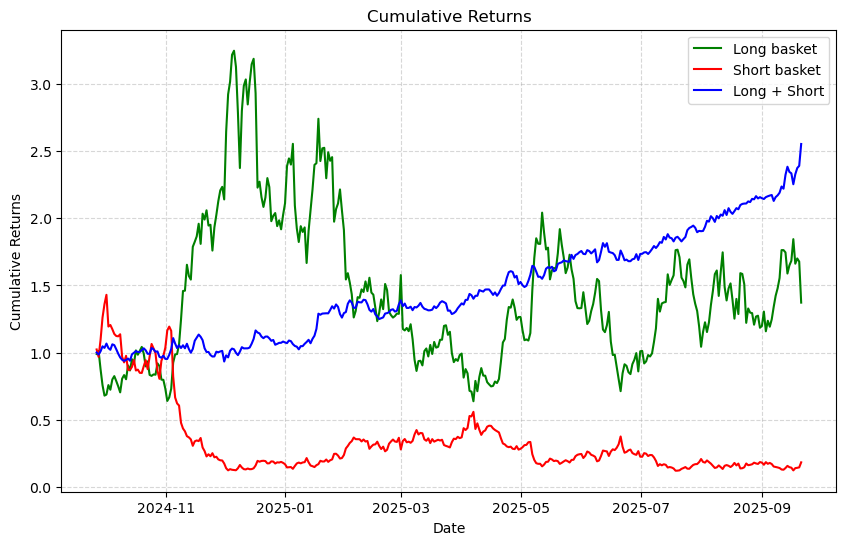

In [10]:
# Compute daily average returns
daily_long = long_basket.groupby("timestamp")["next_returns_funding_volscaled"].mean()
daily_short = short_basket.groupby("timestamp")["next_returns_funding_volscaled"].mean()
daily_long_short = long_short_basket.groupby("timestamp")["next_returns_funding_volscaled"].mean()

# Compute cumulative returns
cum_long = (1 + daily_long).cumprod()
cum_short = (1 + daily_short).cumprod()
cum_long_short = (1 + daily_long_short).cumprod()

# Plot
plt.figure(figsize=(10,6))
plt.plot(cum_long.index, cum_long.values, color='green', label='Long basket')
plt.plot(cum_short.index, cum_short.values, color='red', label='Short basket')
plt.plot(cum_long_short.index, cum_long_short.values, color='blue', label='Long + Short')
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

this is very nice - wont get it this good in production because of trading fees and because of the overfitting done throughout

note (imo its an important point and an insightful way of looking into these things) that doing any type of analysis whatsoever is overfitting - even picking an asset to trade, because your using information you have from the past. what matters is you overfit in a useful way not in a heavy naive path dependant way